In [6]:
# Import all Math tools:
#-----------------------
import numpy as np
from scipy import integrate
from scipy.spatial.distance import directed_hausdorff
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline
plt.style.use('default')

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy
# Figure dpi
dpi = 72

import timeit

import sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    
from matplotlib import animation, rc
from IPython.display import HTML

## Experiment 3: Iterated versions of the Logisitic Map and GP Fit map

### Function Definitions

In [2]:
def time_series_dist(x0,N):
    n = range(0,N)
    xn = []
    for i in n:
        xn.append(x0)
        x0 = f(x0)
    return np.array(xn)

def GP_Predict_Array(X):
    Xstar = np.linspace(X,X, 1).reshape(-1, 1)
    Ystar, Vstar = m.predict(Xstar)
    return Ystar

### Setup

In [3]:
# 1) Choose the kernel. Construct the 1D RBF kernel:
k = GPy.kern.RBF(1,variance=1.,lengthscale=0.1,name="rbf")

# 2) Choose function and r-value. lambda function, call f(x) to generate data
r = 3.5
f = lambda x: r*x*(1-x)  #-np.cos(2*np.pi*x) + 0.5*np.sin(6*np.pi*x)

# 3) Choose number of sample locations
N = 10

# 4) Choose domain of sample points.
X = np.linspace(0, 1, N)[:,None] #[:,None] turns data into column matrix
#X = np.random.uniform(0,1, N)[:,None]
#X = time_series_dist(0.4,N)[:,None] #time_series_dist(x0,N); seeded from x0

In [4]:
# 5) Choose whether to de-clump the sample points:
#X,N = declump(X,N,2)

# 6) Choose how the observed data behave y = f(X) + epsilon
sd = 0
ep = np.random.normal(0., sd, (N,1)) #np.random.normal takes mean and s.d. (not variance), NOTE: 0.1^2 = 0.01; (N,1) => N-by-1 Matrix
Y = f(X) + ep


# ---------------
m = GPy.models.GPRegression(X, Y, k) 

# Constrain the regression parameters to be positive only
m.constrain_positive()

# Fix the Gaussian noise variance at sd**2 if ep != 0 
m.Gaussian_noise.variance = sd**2 # (Reset the parameter first)
m.Gaussian_noise.variance.fix()

# Reoptimise
m.optimize()
display(m)

# New test points to sample function from
Xnew = np.linspace(-0.05, 1.05, 1000)[:, None]

# Get mean and covariance of optimised GP
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

reconstraining parameters GP_regression


### Results

$f$ and its iterated versions

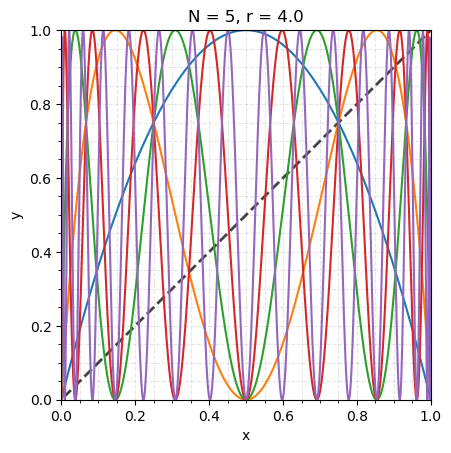

In [58]:
nmax = 5

# Setup plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(Xnew, Xnew, c='#444444', lw=2, ls='--')
ax.set_xlabel("x"), ax.set_ylabel("y")
ax.minorticks_on()
ax.grid(which='minor', alpha=0.3, ls='--')
ax.grid(which='major', alpha=0.3, ls='--')
ax.set_xlim(left=0,right=1);
ax.set_ylim(bottom=0, top=1);
ax.set_aspect('equal', adjustable='box')

#To animate
plot = {}
for i in range(nmax):
    plot["plot{0}".format(i)], = ax.plot([],[],"-")
title_text = ax.set_title('') #"N = " + str(nmax) + ", r = " + str()
# plot1, = ax.plot([],[],"-")
# plot2, = ax.plot([],[],"-")
# plot3, = ax.plot([],[],"-")
# plot4, = ax.plot([],[],"-")
# plot5, = ax.plot([],[],"-")

#Initialize animation
def init():
    temp_list = []
    for i in range(nmax):
        plot["plot{0}".format(i)].set_data([],[])
        temp_list.append(plot["plot{0}".format(i)])
    title_text.set_text('')
    temp_list.append(title_text)
    
    
#     plot["plot1"].set_data([],[])
#     plot2.set_data([],[])
#     plot3.set_data([],[])
#     plot4.set_data([],[])
#     plot5.set_data([],[])
    return temp_list#plot1, plot2, plot3, plot4, plot5

#Update func:
def animate(r):
    f = lambda x: r*x*(1-x)
    Xnew = np.linspace(-0.05, 1.05, 1000)
    y = f(Xnew)
    plot_list = []
    for i in range(nmax):
        plot["plot{0}".format(i)].set_data(Xnew, y)
        y = f(y)
        plot_list.append(plot["plot{0}".format(i)])
    title_text.set_text("N = {iterates}, r = {R}".format(iterates = nmax, R = r))
    plot_list.append(title_text)
    return plot_list
#     plot["plot0"].set_data(Xnew, f(Xnew)) #f
#     plot["plot1"].set_data(Xnew, f(f(Xnew))); #f^2
# #     plot3.set_data(Xnew, f(f(f(Xnew)))); #f^3
# #     plot4.set_data(Xnew, f(f(f(f(Xnew))))); #f^4
# #     plot5.set_data(Xnew, f(f(f(f(f(Xnew)))))); #f^5
#     return plot1, plot1#, plot3, plot4, plot5

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=np.linspace(0,4,50), interval=25, blit=True)
HTML(anim.to_jshtml())

GP fit and its iterated versions

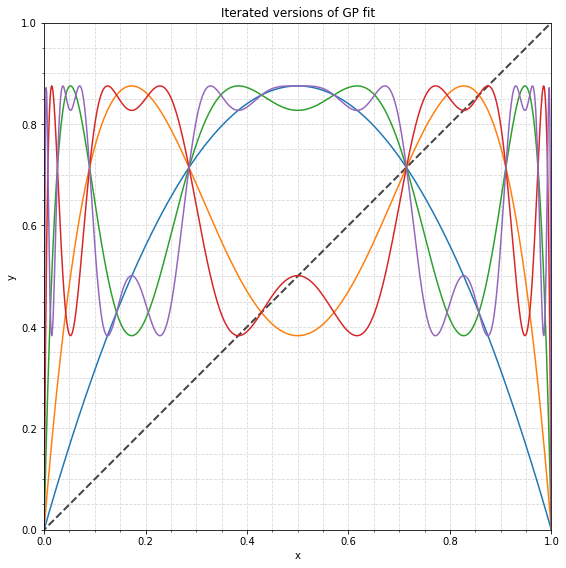

In [59]:
fig = plt.figure(figsize=(20,20),dpi=dpi)
ax = fig.add_subplot(121)
ax.plot(Xnew, Xnew, c='#444444', lw=2, ls='--')
ax.plot(Xnew, GP_Predict_Array(Xnew), "-") #GP
ax.plot(Xnew, GP_Predict_Array(GP_Predict_Array(Xnew)), "-") #GP^2
ax.plot(Xnew, GP_Predict_Array(GP_Predict_Array(GP_Predict_Array(Xnew))), "-") #GP^3
ax.plot(Xnew, GP_Predict_Array(GP_Predict_Array(GP_Predict_Array(GP_Predict_Array(Xnew)))), "-") #GP^4
ax.plot(Xnew, GP_Predict_Array(GP_Predict_Array(GP_Predict_Array(GP_Predict_Array(GP_Predict_Array(Xnew))))), "-") #GP^5


# Organize plot
ax.set_xlabel("x"), ax.set_ylabel("y")
ax.set_title("Iterated versions of GP fit")
ax.minorticks_on()
ax.grid(which='minor', alpha=0.3, ls='--')
ax.grid(which='major', alpha=0.3, ls='--')
ax.set_xlim(left=0,right=1);
ax.set_ylim(bottom=0, top=1);
ax.set_aspect('equal', adjustable='box')